# Prediction stock returns with linear regression

## Imports & Settings

In [149]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [150]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [151]:
YEAR = 252

## Load Data

In [158]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [159]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

### Select Investment Universe

In [160]:
data = data[data.dollar_vol_rank<100]

In [161]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109663 entries, (AAL, 2013-07-24 00:00:00) to (ZTS, 2014-12-09 00:00:00)
Data columns (total 44 columns):
volume                   109663 non-null float64
dollar_vol               109663 non-null float64
dollar_vol_rank          109663 non-null float64
rsi                      109663 non-null float64
bb_high                  109663 non-null float64
bb_low                   109663 non-null float64
atr                      109663 non-null float64
macd                     109663 non-null float64
return_1d                109663 non-null float64
return_5d                109663 non-null float64
return_10d               109663 non-null float64
return_21d               109663 non-null float64
return_42d               109663 non-null float64
return_63d               109663 non-null float64
target_1d                109663 non-null float64
target_5d                109663 non-null float64
target_10d               109663 non-null float64
target_21d 

### Create Model Data

In [162]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Custom MultipleTimeSeriesCV

In [236]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Verify that it works

In [248]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [249]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


## Linear Regression with sklearn

### Generate predictions with LinearRegression 

In [198]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1 

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

target = f'target_{lookahead}d'
test_results, result_idx, preds = [], [], []
ics = 0
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    if len(y_test) < 50:
        continue
    lr.fit(X=X_train, y=y_train)

    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    ic, pval = spearmanr(y_pred, y_test)
    ics += ic
    if i % 100 == 0:
        print(f'{i:03} | {ics/i:>7.2%}')

    test_results.append([rmse, ic, pval])
    preds.append(y_test.to_frame('actuals').assign(predicted=y_pred))
    result_idx.append(y_test.index.get_level_values('date').min())

lr_result = pd.DataFrame(test_results,
                         columns=['rmse', 'ic', 'pval'],
                         index=result_idx)
lr_result.dropna().to_hdf('data.h5', 'lr/metrics')
pd.concat(preds).to_hdf('data.h5', 'lr/predictions')

In [199]:
lr_result = pd.read_hdf('data.h5', 'lr/metrics')
lr_preds = pd.read_hdf('data.h5', 'lr/predictions')

In [200]:
r, p = spearmanr(lr_preds.actuals, lr_preds.predicted)
print(f'Information Coefficient (overall): {r:.3%} (p-value: {p:.4%})')

Information Coefficient (overall): 1.667% (p-value: 0.0006%)


In [201]:
def plot_ic_distribution(df, fname=None, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2%}\nMedian: {median:5.2%}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)    

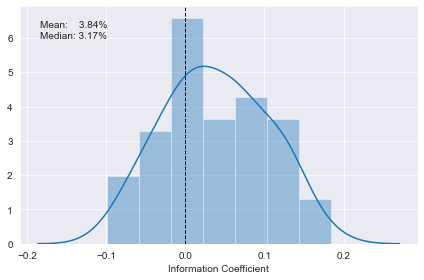

In [202]:
plot_ic_distribution(lr_result, fname='lr_ic_dist')

In [203]:
def plot_rolling_ic(df, fname):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    rolling_result.ic.plot(ax=axes[0], title='Information Coefficient', lw=1)
    axes[0].axhline(0, lw=1, ls='--', color='k')

    rolling_result.rmse.plot(ax=axes[1], title='Root Mean Squared Error', lw=1, ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    plt.tight_layout()
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

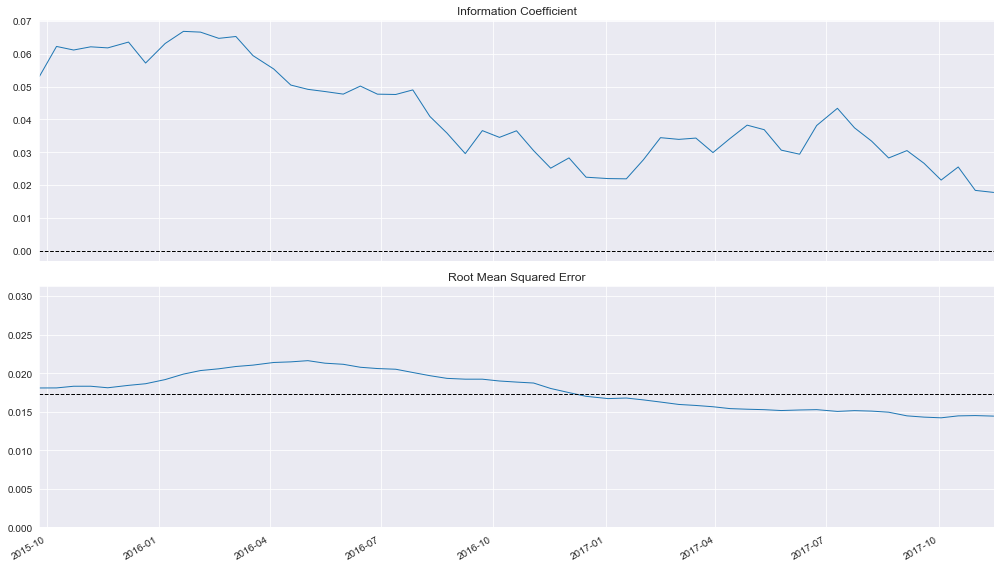

In [225]:
plot_rolling_ic(lr_result, fname='lr_ic_rolling')

In [226]:
def plot_preds_scatter(df, ticker=None, fname=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw':1, 'color':'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      stat_func=spearmanr,
                      kind='reg')
    j. ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j. ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j. ax_joint.set_xlabel('Predicted')
    j. ax_joint.set_ylabel('Actuals')
    if fname is not None:
        plt.savefig(Path('figures', fname), dpi=300)

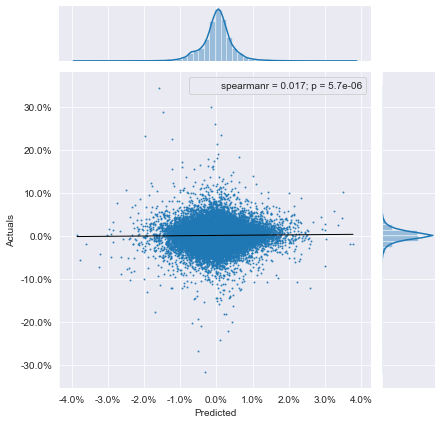

In [227]:
plot_preds_scatter(lr_preds, fname='lr_preds')

## Ridge Regression

In [209]:
alphas = np.logspace(-4, 4, 9)
alphas = sorted(list(alphas) + list(alphas * 5))

n_splits = int(3 * YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1 
target = f'target_{lookahead}d'

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

X = X.drop([c for c in X.columns if 'year' in c], axis=1)
ridge_coeffs, ridge_results, preds = {}, [], []
for alpha in alphas:
    print(alpha)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 40:
            continue

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        ridge_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 10 == 0:
            print(f'{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
ridge_results = pd.DataFrame(ridge_results, columns=cols)
ridge_results.to_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf('data.h5', 'ridge/coeffs')
pd.concat(preds).to_hdf('data.h5', 'ridge/predictions')

0.0001
  0.2 | 010 |  -0.13% |   1.50%
  0.4 | 020 |   1.47% |   1.45%
  0.6 | 030 |   2.93% |   1.51%
  0.8 | 040 |   2.42% |   1.54%
  0.9 | 050 |   3.12% |   1.68%
  1.1 | 060 |   3.26% |   1.75%
  1.3 | 070 |   3.84% |   1.72%
0.0005
  0.3 | 010 |  -0.13% |   1.50%
  0.5 | 020 |   1.47% |   1.45%
  0.6 | 030 |   2.93% |   1.51%
  0.8 | 040 |   2.42% |   1.54%
  1.0 | 050 |   3.12% |   1.68%
  1.2 | 060 |   3.26% |   1.75%
  1.4 | 070 |   3.84% |   1.72%
0.001
  0.2 | 010 |  -0.13% |   1.50%
  0.4 | 020 |   1.47% |   1.45%
  0.6 | 030 |   2.93% |   1.51%
  0.8 | 040 |   2.42% |   1.54%
  1.0 | 050 |   3.12% |   1.68%
  1.2 | 060 |   3.26% |   1.75%
  1.4 | 070 |   3.84% |   1.72%
0.005
  0.2 | 010 |  -0.13% |   1.50%
  0.4 | 020 |   1.47% |   1.45%
  0.6 | 030 |   2.93% |   1.51%
  0.8 | 040 |   2.42% |   1.54%
  1.0 | 050 |   3.12% |   1.68%
  1.2 | 060 |   3.26% |   1.75%
  1.4 | 070 |   3.84% |   1.72%
0.01
  0.2 | 010 |  -0.13% |   1.50%
  0.4 | 020 |   1.47% |   1.45%
  0.6 | 0

### Evaluate Ridge Results

In [210]:
ridge_results = pd.read_hdf('data.h5', 'ridge/metrics')
ridge_coeffs = pd.read_hdf('data.h5', 'ridge/coeffs')
ridge_preds = pd.read_hdf('data.h5', 'ridge/predictions')

In [211]:
ridge_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1350 entries, 0 to 1349
Data columns (total 6 columns):
alpha    1350 non-null float64
split    1350 non-null int64
date     1350 non-null datetime64[ns]
rmse     1350 non-null float64
ic       1350 non-null float64
pval     1350 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 73.8 KB


In [212]:
print(ridge_results.groupby('alpha').ic.describe())

            count      mean       std       min       25%       50%       75%       max
alpha                                                                                  
0.0001       75.0  0.038422  0.064344 -0.095696 -0.009415  0.033088  0.081100  0.183850
0.0005       75.0  0.038422  0.064345 -0.095696 -0.009415  0.033088  0.081098  0.183850
0.0010       75.0  0.038422  0.064344 -0.095696 -0.009415  0.033088  0.081098  0.183850
0.0050       75.0  0.038422  0.064344 -0.095696 -0.009415  0.033088  0.081100  0.183850
0.0100       75.0  0.038422  0.064344 -0.095696 -0.009415  0.033088  0.081103  0.183850
0.0500       75.0  0.038423  0.064345 -0.095714 -0.009423  0.033094  0.081110  0.183862
0.1000       75.0  0.038422  0.064342 -0.095733 -0.009418  0.033100  0.081105  0.183860
0.5000       75.0  0.038422  0.064336 -0.095706 -0.009378  0.033082  0.081129  0.183899
1.0000       75.0  0.038431  0.064327 -0.095694 -0.009329  0.033064  0.081140  0.183874
5.0000       75.0  0.038450  0.0

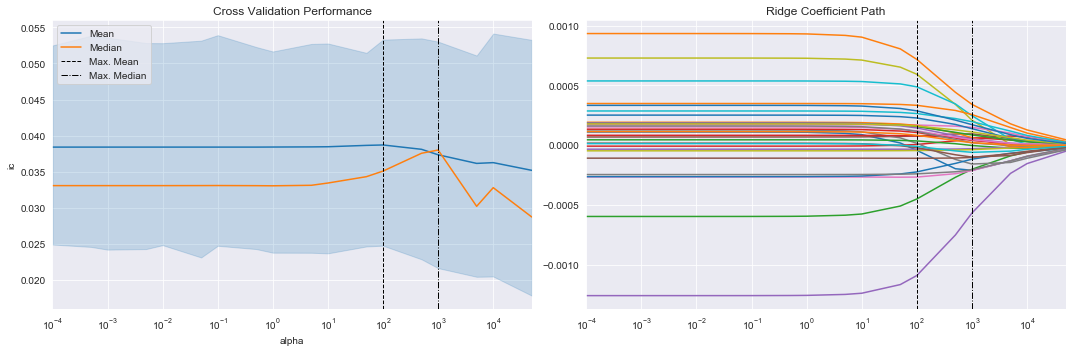

In [232]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=ridge_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = ridge_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                 title='Ridge Coefficient Path')
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/ridge_path', dpi=300);

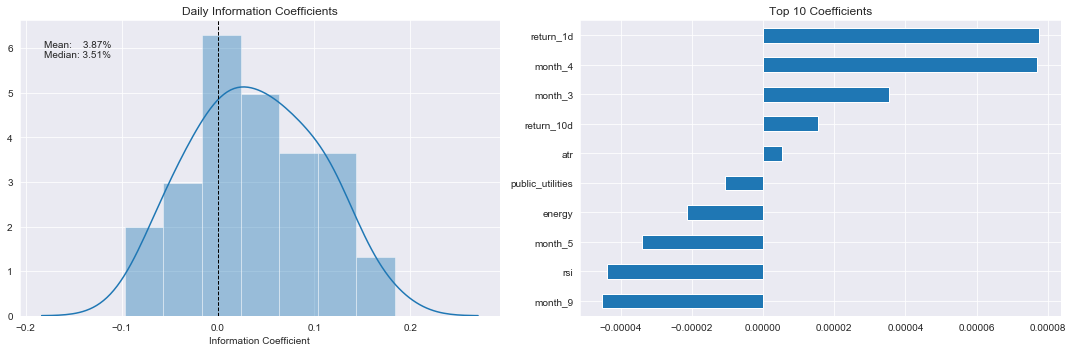

In [230]:
best_alpha = 100
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_results[ridge_results.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/ridge_top_coeffs', dpi=300);

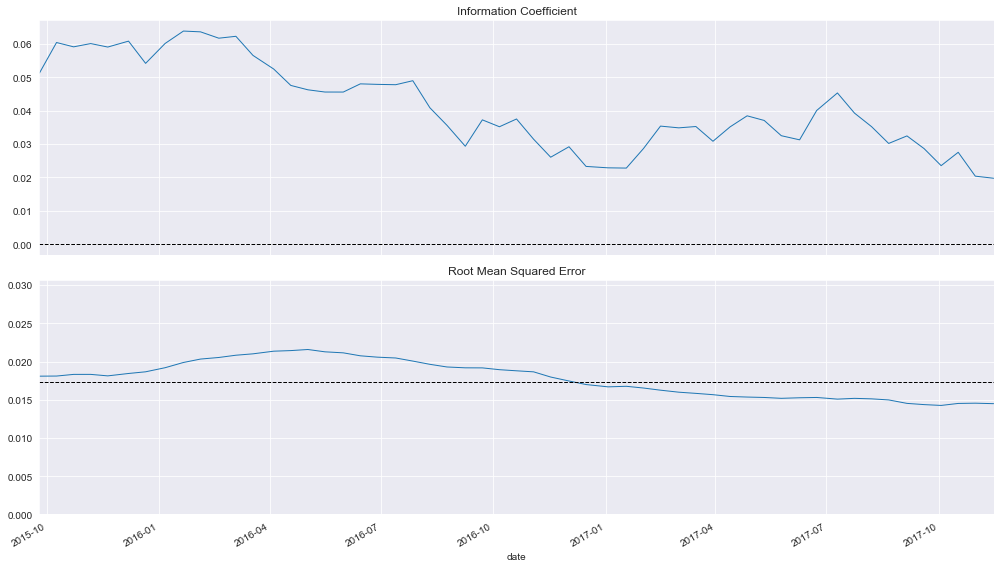

In [231]:
plot_rolling_ic(ridge_results[ridge_results.alpha==0.01].set_index('date'), fname='ridge_ic_rolling')

## Lasso CV

In [217]:
alphas = np.logspace(-10, -3, 8)

train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length) # three years
lookahead = 1 
target = f'target_{lookahead}d'

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

lasso_coeffs, coeffs, lasso_results, preds = {}, [], [], []
for alpha in alphas:
    print(alpha)
    start = time()
    model = Lasso(alpha=alpha,
                  fit_intercept=False, # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = rmses = 0
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        if len(y_test) < 10:
            continue
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        ic, pval = spearmanr(y_pred, y_test)

        preds.append(y_test.to_frame('actuals').assign(
            predicted=y_pred, alpha=alpha))
        date = y_test.index.get_level_values('date').min()
        lasso_results.append([alpha, i, date, rmse, ic, pval])
        coeffs.append(pipe['model'].coef_)
        ics += ic
        rmses += rmse
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {rmses/i:>7.2%}')

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

cols = ['alpha', 'split', 'date', 'rmse', 'ic', 'pval']
lasso_results = pd.DataFrame(lasso_results, columns=cols)
lasso_results.to_hdf('data.h5', 'lasso/metrics')
lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns)
lasso_coeffs.to_hdf('data.h5', 'lasso/coeffs')
pd.concat(preds).to_hdf('data.h5', 'lasso/predictions')

1e-10
	  0.9 | 010 |   0.41% |   1.50%
	  1.8 | 020 |   1.81% |   1.45%
	  3.0 | 030 |   3.07% |   1.51%
	  3.9 | 040 |   2.40% |   1.54%
	  4.9 | 050 |   3.39% |   1.67%
	  6.2 | 060 |   3.96% |   1.75%
	  6.9 | 070 |   4.45% |   1.72%
1e-09
	  0.8 | 010 |   0.41% |   1.50%
	  1.6 | 020 |   1.81% |   1.45%
	  2.5 | 030 |   3.07% |   1.51%
	  3.4 | 040 |   2.40% |   1.54%
	  4.3 | 050 |   3.39% |   1.67%
	  5.4 | 060 |   3.96% |   1.75%
	  6.2 | 070 |   4.45% |   1.72%
1e-08
	  0.8 | 010 |   0.42% |   1.50%
	  1.5 | 020 |   1.81% |   1.45%
	  2.5 | 030 |   3.07% |   1.51%
	  3.7 | 040 |   2.40% |   1.54%
	  4.7 | 050 |   3.39% |   1.67%
	  6.0 | 060 |   3.97% |   1.75%
	  7.0 | 070 |   4.46% |   1.72%
1e-07
	  0.6 | 010 |   0.44% |   1.50%
	  1.2 | 020 |   1.80% |   1.45%
	  2.1 | 030 |   3.09% |   1.51%
	  3.0 | 040 |   2.43% |   1.54%
	  3.7 | 050 |   3.42% |   1.67%
	  4.5 | 060 |   3.99% |   1.75%
	  5.1 | 070 |   4.50% |   1.72%
1e-06
	  0.6 | 010 |   0.56% |   1.50%
	  1.0 | 020 

### Evaluate Lasso Results

In [218]:
lasso_results.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-10,0.044513,0.057051
1.000000e-09,0.044519,0.057051
1.000000e-08,0.044584,0.057054
1.000000e-07,0.044975,0.057061
1.000000e-06,0.045167,0.044167
1.000000e-05,0.044732,0.042469
1.000000e-04,0.043184,0.036074
1.000000e-03,0.029272,0.038067


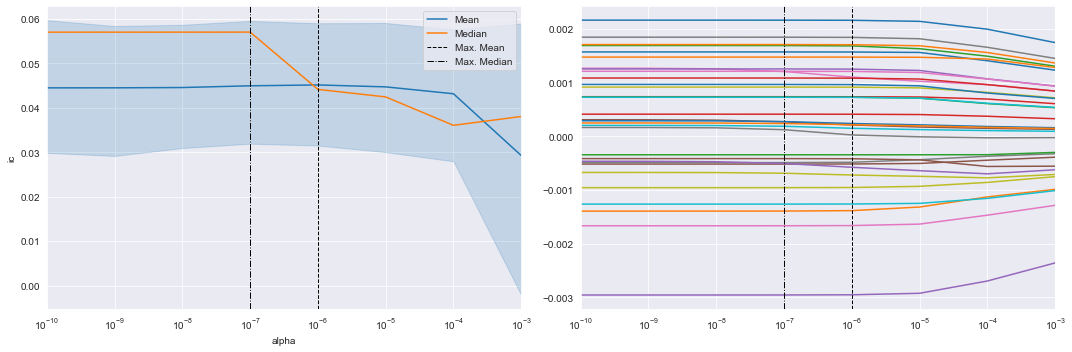

In [234]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

ax = sns.lineplot(x='alpha', y='ic', data=lasso_results,
                  estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = lasso_results.groupby('alpha').ic.agg(['mean', 'median'])
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')
axes[0].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')

lasso_coeffs.T.plot(logx=True,
                  legend=False,
                  ax=axes[1])
axes[1].axvline(by_alpha['mean'].idxmax(), ls='--',
                c='k', lw=1, label='Max. Mean')
axes[1].axvline(by_alpha['median'].idxmax(), ls='-.',
                c='k', lw=1, label='Max. Median')
fig.tight_layout()
fig.savefig('figures/lasso_path', dpi=300);

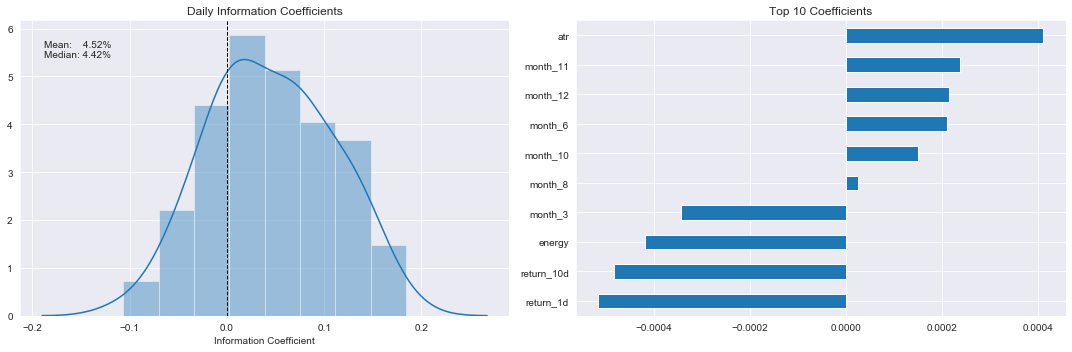

In [235]:
best_alpha = lasso_results.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_results[lasso_results.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = lasso_coeffs.T.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.T.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')
fig.tight_layout()
fig.savefig('figures/lasso_top_coeffs', dpi=300);